<a href="https://colab.research.google.com/github/sayid-alt/AEP-Hourly-Energy-Consumption-Prediction/blob/main/AEP_Hourly_Energy_Consumption_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [105]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import urllib.request
import zipfile

# Utilities

In [106]:
# Download data
def download_data(url, file_path):
  os.makedirs(file_path, exist_ok=True) # Create download file directory if it doesn't exist
  print('Successfully creating directory:', file_path)

  zip_path = os.path.join(file_path, 'AEP_hourly.csv.zip') # Define zip path for downloaded file

  urllib.request.urlretrieve(url, zip_path) # retreive file from url
  print('Downloaded file:', zip_path)

  # open and extract all files from zip
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(file_path)
    print('Extracted all files from:', zip_path)

  # remove zip file
  os.remove(zip_path)
  print('Removed zip file:', zip_path)

# Load data
def load_AEP_data(file_path):
  # csv file path
  csv_path = os.path.join(file_path, 'AEP_hourly.csv')

  # return pandas dataset format
  return pd.read_csv(csv_path, parse_dates=['Datetime']).sort_values('Datetime', ascending=True).reset_index()


# plot series
def plot_series(time, series,
                format='-', xlabel="Time", ylabel="Mv", title='Time Series Plot',
                start=0, end=None, label=None, color='skyblue', ax=None):

    if ax is None:
      fig, ax = plt.subplots(figsize=(10,5))

    ax.plot(time[start:end], series[start:end], label=label, color=color)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label:
        ax.legend(fontsize=14)
    plt.grid(True)


# Download the data

In [107]:
# Dataset URL stored in github repository
DOWNLOAD_URL = 'https://github.com/sayid-alt/AEP-Hourly-Energy-Consumption-Prediction/raw/main/datasets/AEP_hourly.csv.zip'

# Directory where dataset will be stored
FILE_PATH = os.path.join(os.getcwd(), 'datasets')

# Download dataset
download_data(DOWNLOAD_URL, FILE_PATH)

Successfully creating directory: /content/datasets
Downloaded file: /content/datasets/AEP_hourly.csv.zip
Extracted all files from: /content/datasets/AEP_hourly.csv.zip
Removed zip file: /content/datasets/AEP_hourly.csv.zip


## Load Data

In [108]:
AEP_hourly = load_AEP_data(FILE_PATH)
AEP_hourly.head()

,index,Datetime,AEP_MW
0,2183,2004-10-01 01:00:00,12379.0
1,2184,2004-10-01 02:00:00,11935.0
2,2185,2004-10-01 03:00:00,11692.0
3,2186,2004-10-01 04:00:00,11597.0
4,2187,2004-10-01 05:00:00,11681.0


# Data Preprocessing

When data is loaded, it sorted based on the `Datetime` column. It causes unsorted index value. So we have to reset the new index value and drop the unsorted index values.

In [109]:
# Drop index column
AEP_hourly.drop(columns=['index'], axis=1, inplace=True)
AEP_hourly.head()

,Datetime,AEP_MW
0,2004-10-01 01:00:00,12379.0
1,2004-10-01 02:00:00,11935.0
2,2004-10-01 03:00:00,11692.0
3,2004-10-01 04:00:00,11597.0
4,2004-10-01 05:00:00,11681.0


In [110]:
AEP_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [111]:
AEP_hourly.count()

,0
Datetime,121273
AEP_MW,121273


## Missing Value

In [112]:
AEP_hourly.isnull().sum()
#No missing values

,0
Datetime,0
AEP_MW,0


## Duplicate Value

In [113]:
AEP_hourly.duplicated().sum()
#No duplicate values

0

## Visualization

Look the big picture of the time series pattern from the whole datasets. We'll show it in the plot below

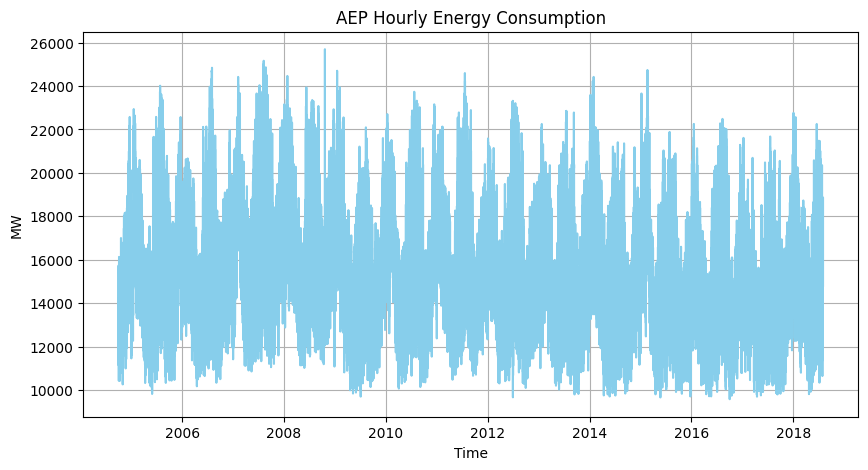

In [114]:

plot_series(AEP_hourly['Datetime'],
            AEP_hourly['AEP_MW'], xlabel='Time',
            ylabel='MW', title='AEP Hourly Energy Consumption')

The graph shows a clear trend where energy consumption from `2006-2010` was relatively higher, marked by frequent peaks reaching above `22,000 MW`. However, starting from 2010 onward, there is a noticeable decline in the consumption peaks, which stabilize and remain mostly below 20,000 MW in the later years.


Then, we'll try to take a look the seosonality more closely within a year. We've seen the data range is in hour steps. So to make the one year ranga of data we calculate `24 * 365`. Which `24` is hours a day, and `365` is days a year. <br>
<br>
For ease of organize the code, we declare variable for the ranges of datasets as below:<br>
```python
one_year = 24 * 365
one_month = 24 * 30
one_week = 24 * 7
one_day = 24
```

In [115]:
one_year = 24 * 365
one_month = 24 * 30
one_week = 24 * 7
one_day = 24

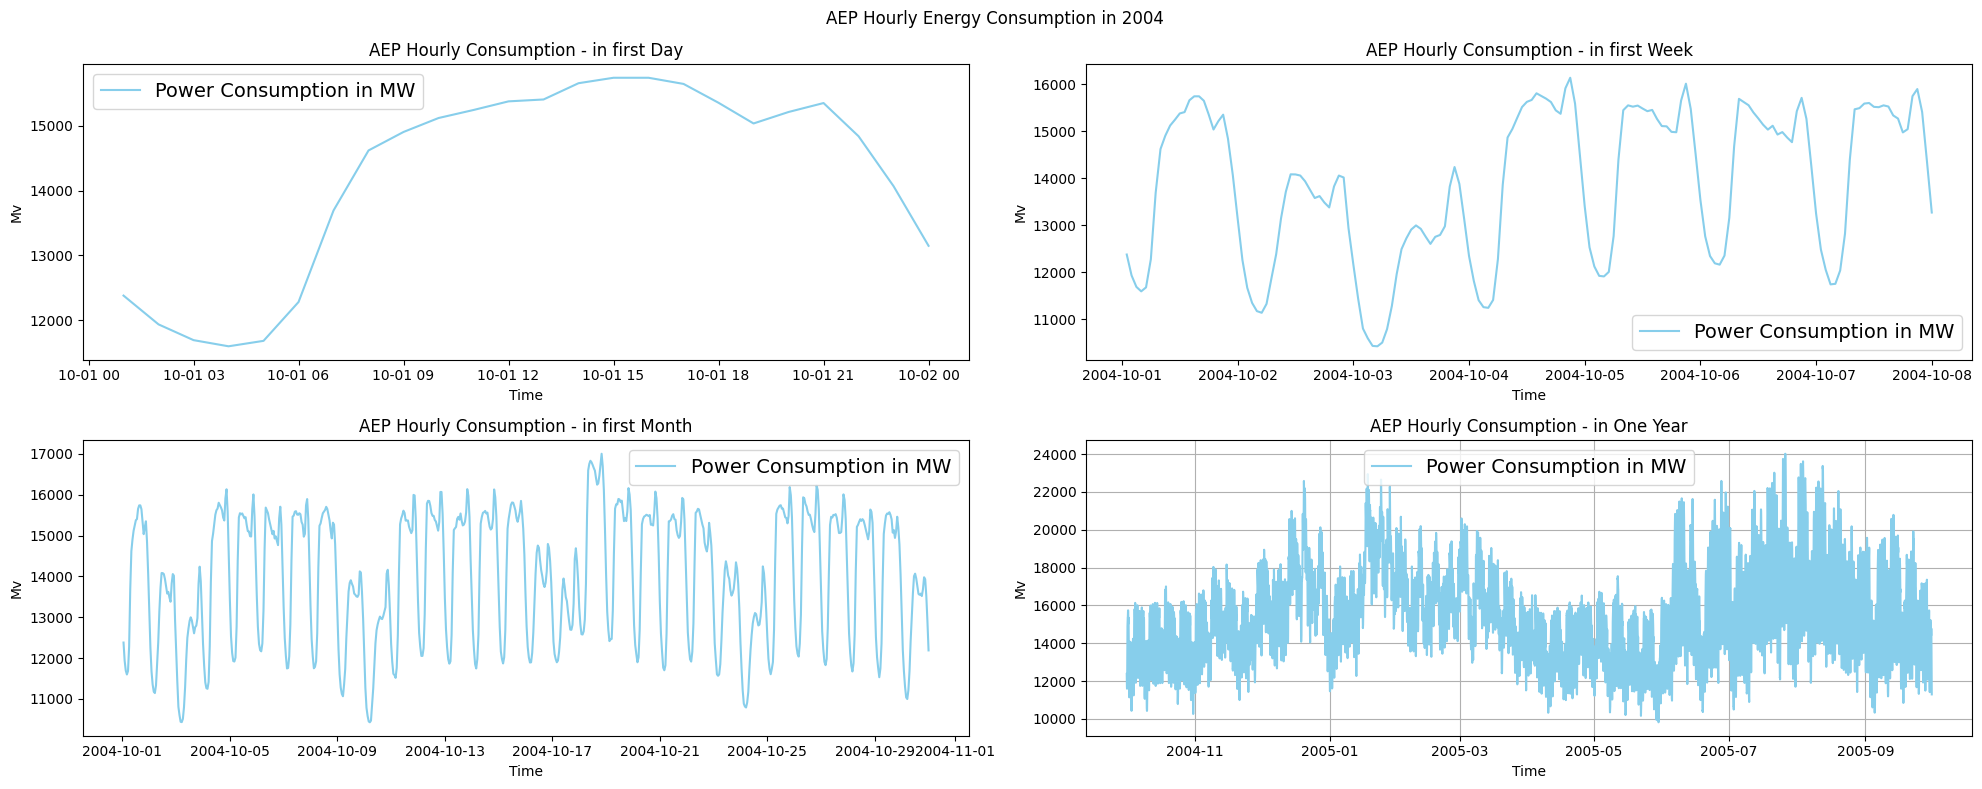

In [116]:
# Create subplots: 2 rows and 2 columns
fig, ax = plt.subplots(figsize=(20, 8), ncols=2, nrows=2)
fig.suptitle('AEP Hourly Energy Consumption in 2004')
# Plot for one day
plot_series(AEP_hourly['Datetime'], AEP_hourly['AEP_MW'],
            title='AEP Hourly Consumption - in first Day',
            start=0, end=one_day, label='Power Consumption in MW',
            ax=ax[0, 0])

# Plot for one week
plot_series(AEP_hourly['Datetime'], AEP_hourly['AEP_MW'],
            title='AEP Hourly Consumption - in first Week',
            start=0, end=one_week, label='Power Consumption in MW',
            ax=ax[0, 1])

# Plot for one month
plot_series(AEP_hourly['Datetime'], AEP_hourly['AEP_MW'],
            title='AEP Hourly Consumption - in first Month',
            start=0, end=one_month, label='Power Consumption in MW',
            ax=ax[1, 0])

# Plot for one year
plot_series(AEP_hourly['Datetime'], AEP_hourly['AEP_MW'],
            title='AEP Hourly Consumption - in One Year',
            start=0, end=one_year, label='Power Consumption in MW',
            ax=ax[1, 1])

# Adjust layout for better spacing
plt.tight_layout()


## Usage Distribution of power mw

In [163]:
def plot_dist(data):
  fig, axs = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
  fig.suptitle('Distribution of AEP_MW')

  sns.histplot(data=data, x='AEP_MW', bins=25, color='skyblue', ax=axs[0], kde=True)
  sns.boxplot(data=data, x='AEP_MW', color='skyblue', ax=axs[1])

  plt.tight_layout()

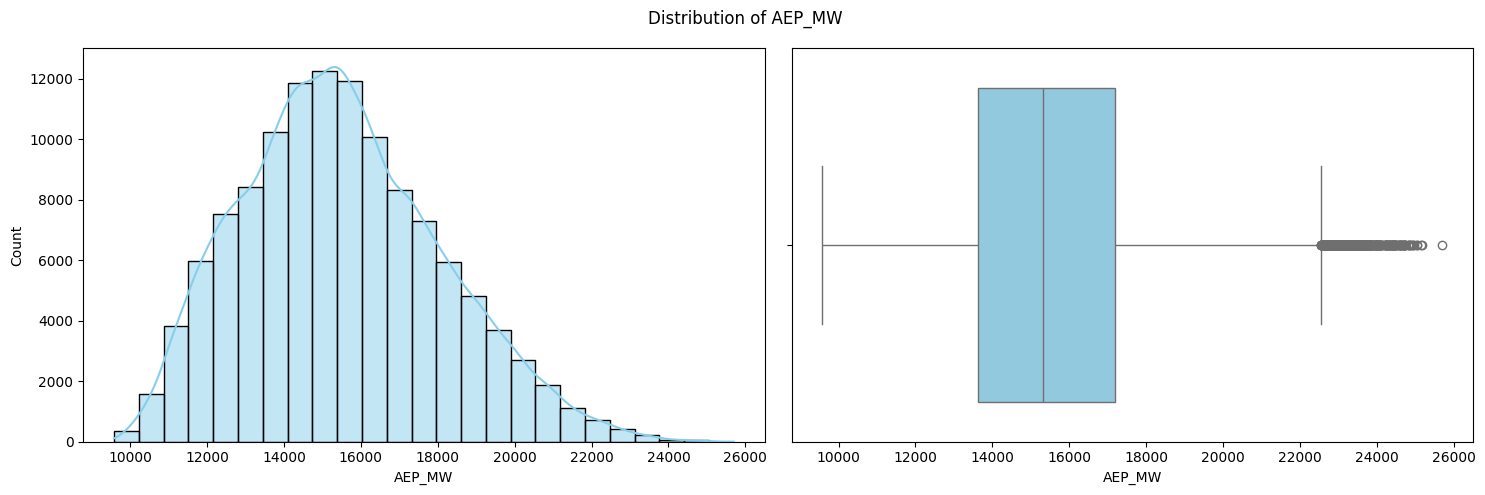

In [165]:
plot_dist(AEP_hourly)

## Check the outlier

Boxplot that displayed in the previous section tells that data has a outliers data point. Well, hecking for outliers in data can significantly improve the accuracy of calculating the mean and understanding the data's distribution, making it more normally distributed. On the other hand, outliers can distort the mean, leading to unreliable or skewed results.

In [166]:
def print_outliers(data):
  q1, q2, q3 = np.percentile(AEP_hourly['AEP_MW'], [25, 50, 75])
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  data = data[(data['AEP_MW'] < lower_bound) | (data['AEP_MW'] > upper_bound)]
  data.sort_values(by='Datetime', ascending=True)
  return data

In [167]:
outliers_data = print_outliers(AEP_hourly)
outliers_data

,Datetime,AEP_MW
1927,2004-12-20 09:00:00,22577.0
2622,2005-01-18 08:00:00,22940.0
2623,2005-01-18 09:00:00,22886.0
2766,2005-01-24 08:00:00,22652.0
2767,2005-01-24 09:00:00,22639.0
...,...,...
116169,2018-01-02 08:00:00,22685.0
116170,2018-01-02 09:00:00,22744.0
116193,2018-01-03 08:00:00,22759.0
116194,2018-01-03 09:00:00,22624.0


In [168]:
# Get the number of rows in the dataframe.
num_rows = outliers_data.shape[0]

# Print the number of rows.
print(f"Number of outliers data: {num_rows}")

# print the percentage of number of outliers
print(f"Percentage of outliers data: {round(num_rows / AEP_hourly.shape[0] * 100, 2)}%")

Number of outliers data: 667
Percentage of outliers data: 0.55%


The dataset contains 667 outliers, which represent approximately 0.55% of the total data. While this is a relatively small proportion, the presence of these outliers can still significantly distort the overall distribution and affect key statistics like the mean, potentially leading to misleading conclusions.
<br><br>
Therefore, the code below will drop that outliers data, then we'll see how it changes the distribution shape plot.

In [169]:
# Drop the outliers from the dataframe.
AEP_hourly.drop(outliers_data.index, inplace=True)

In [170]:
AEP_hourly.shape

(120606, 2)

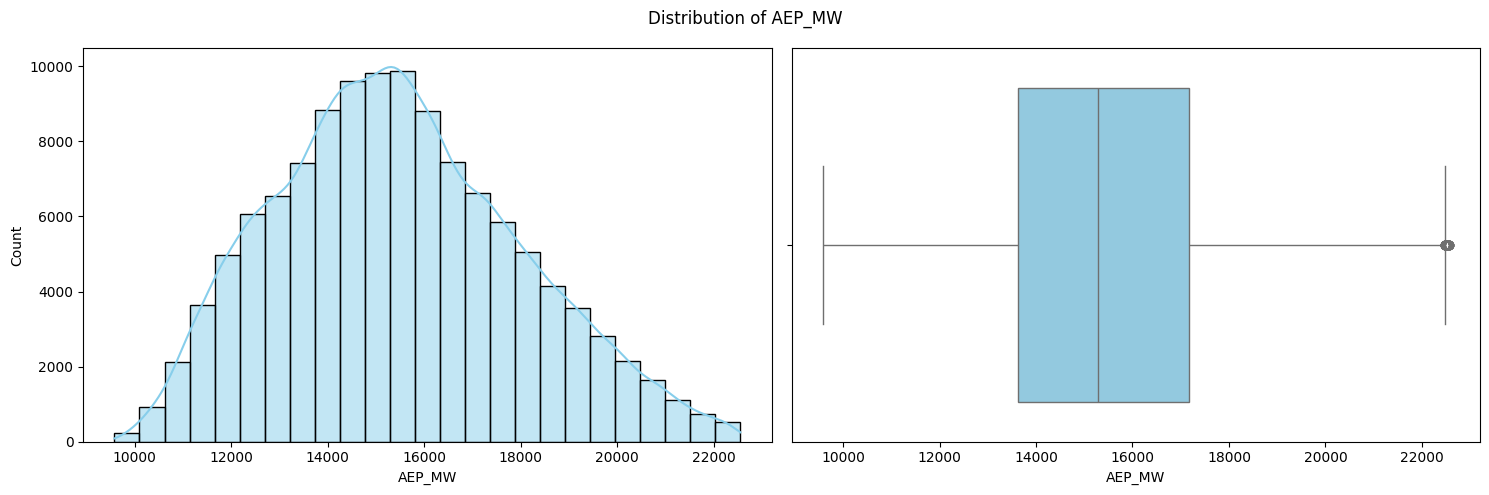

In [171]:
plot_dist(AEP_hourly)

# Exploratory Data Analyst

In [78]:
AEP_hourly.describe()

,Datetime,AEP_MW
count,121273,121273.000000
mean,2011-09-02 03:17:01.553025024,15499.513717
min,2004-10-01 01:00:00,9581.000000
25%,2008-03-17 15:00:00,13630.000000
50%,2011-09-02 04:00:00,15310.000000
75%,2015-02-16 17:00:00,17200.000000
max,2018-08-03 00:00:00,25695.000000
std,NaN,2591.399065
